# CS146 Project 2: Discrete and multi-level models


Here is a data set of kelp plant counts near the coast. The coastal area was divided into 100 20 m × 20 m grid squares and the number of kelp was painstakingly counted in each grid square. Unfortunately, some of the grid squares were not counted.

Your task is to fit an appropriate discrete count model for this data set and to estimate the number of kelp in the missing cells.

Prior knowledge: We expect something like 0 to 2 kelp plants per square meter. Note: Each grid square has an area of 400 m².

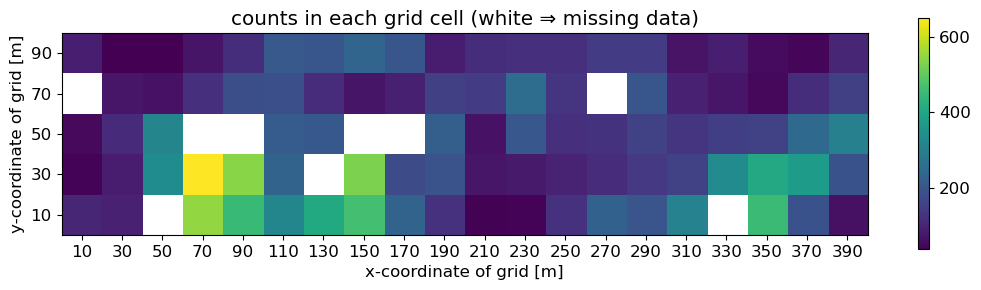

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

Come up with a strategy for estimating the values of the missing cells. How can you use the cell values you have to estimate/predict the values of the cells you don’t have? Describe your strategy to the client.

## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

## Strategy

To estimate the missing cells, the number of kelps for missing grids should not be too out of place comparing to its surrounding neighbor. A hierarchal model that considers clusters should help. This allows neighboring grids to be partially considered when estimating the missing values. The overall grid, and its neighbors should also be accounted when estimating the number of kelps in the missing grid cell. 

To do that, we will create a linear model that considers the kelp's x and y values, overall grid of kelps to estimate the number of kelps in missing grid cells. 

## Data Pre-processing

Data pre-processing is done to assign each data value with their respective x and y coordinates

In [3]:
import pymc as pm
import arviz as az
import scipy.stats as sts
import pandas as pd
summary = []
for i in range(len(data)):
    for j in range(len(data[0])):
        if np.isnan(data[i][j]) == False:
            summary.append([data[i][j],i,j]) #append a list of counts with its x and y values             
                
df = pd.DataFrame(summary, columns=['counts', 'x_coord', 'y_coord'])   

/opt/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Partial Pooling 

In partial pooling, we want to cluster cells based on their respective x and y coordinates. We can assume just from looking at the visualisation that y values that are larger seem to have less kelp count, and clusters of grid cells with low y-coordinates sometimes have large kelp count values. Thus, it is important to have a hierarchal model so that we can allow it to be dependent on other grid cells based on the x-y coordinates. This allows neighboring grid cells to have higher infleunce. This is facilitated by pymc's sampler. 
 

$$Count_{i} \sim Poisson(\lambda_{i}\cdot SIZE)$$

A non-centered paramaterisation is done because there are divergence errors created in pymc. This would allow more effective samples in ESS.

We know that both row and column are both variables that would affect the mean and variance of our unique log odds. They are both included in the prior, multiplying by thie unique sigmas. 

$$log(\lambda_{i}) = \bar{\alpha} +x_{\textrm{ROW[i]}} \sigma_{x} + y_{\textrm{COL[i]}}\sigma_{y}$$

or 

$$\lambda_{i} = e^{\bar{\alpha} +x_{\textrm{ROW[i]}}\sigma_{x} + y_{\textrm{COL[i]}}\sigma_{y}}$$

The adaptive priors of x and y is normally distributed between 0 and 1 from sensitivity analysis of comparing it with uniform distribution. 

The main advantage of adaptive priors is that they can help to improve the accuracy and efficiency of Bayesian analyses. By allowing the prior to vary based on the available data, the resulting posterior distribution can be more informative and better reflect the data. This can be particularly useful in situations where the prior is uncertain or where the data is sparse or noisy.

Number of rows = 5 (0 to 4)
$$x_{i} \sim \textrm{Normal}(0, 1) ~~ \textrm{for i = 0...4}$$

Number of columns = 20 (0 to 19)
$$y_{i} \sim \textrm{Normal}(0, 1) ~~ \textrm{for i = 0...19}$$

The prior are tested out with the normal pdf distribution same as above and set to be:

$$\bar{\alpha} \sim Normal(0.1,0.5)$$
$$\sigma_{x} \sim Exponential(25)$$
$$\sigma_{y} \sim Exponential(25)$$

In [14]:
#Partial pooling
SIZE = 400
nrow = 5
ncol = 20 
x_coord = df.x_coord.values
y_coord = df.y_coord.values

with pm.Model() as m_p:
    
    # Hyperparameters
    a_bar = pm.Normal('a_bar', mu=0.1, sigma=0.5)
    sigma_x = pm.Exponential('sigma_x', lam=25) 
    sigma_y = pm.Exponential('sigma_y', lam=25)
    
    # Adaptive prior
    x = pm.Normal('x', shape=nrow, mu=0, sigma=1)
    y = pm.Normal('y', shape=ncol, mu=0, sigma=1)
    l = pm.Deterministic('l', pm.math.exp((a_bar + x[x_coord]*
                                           sigma_x + y[y_coord]*
                                           sigma_y))*SIZE)
    
    # Likelihood
    counts = pm.Poisson('counts', mu=l, observed=df.counts.values)
    
    # Sample prior predictive from partial pooling 
    p_samples = pm.sample_prior_predictive(10000)

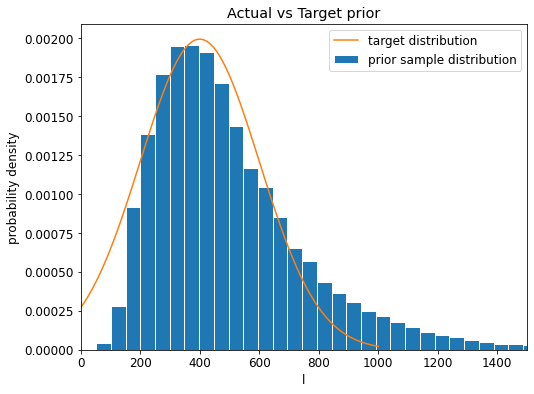

In [15]:
# Actual prior 
plt.figure(figsize=(8, 6))
plt.hist(
    p_samples.prior.l.values.flat,
    bins=100, 
    edgecolor='white', density=True, label='prior sample distribution')

# Target prior 
plt.xlim(0, 1500)
x = np.linspace(0, 1000, 100)
plt.plot(x, sts.norm.pdf(x, loc=400, scale=200), color='C1', 
         label='target distribution')

plt.xlabel("l")
plt.ylabel("probability density")
plt.title("Actual vs Target prior")
plt.legend()
plt.show()

I increased the tuning to 3200, with a target acceptance of 0.97 so that r_hat can fit better to 1.0. However, there are still some instances where r_hat is 1.01. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_x, sigma_y, x, y]


Sampling 4 chains for 3_200 tune and 1_000 draw iterations (12_800 + 4_000 draws total) took 157 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ffa149a0>,
      dtype=object)

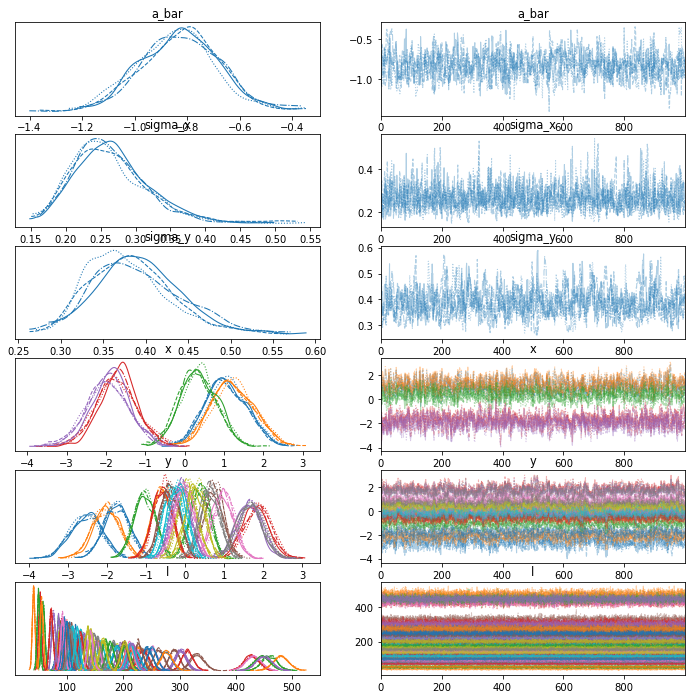

In [16]:
with m_p:
    partial_inf = pm.sample(tune=3200, target_accept=0.97)
    pm.sample_posterior_predictive(partial_inf, extend_inferencedata=True)

az.plot_trace(partial_inf, var_names=['a_bar','sigma_x','sigma_y','x','y','l'])

In [17]:
pd.set_option('display.max_rows', None)
az.summary(partial_inf, var_names=['a_bar','sigma_x','sigma_y','x','y', 'l'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.828,0.150,-1.138,-0.574,0.006,0.004,735.0,953.0,1.00
sigma_x,0.264,0.054,0.176,0.369,0.002,0.001,1020.0,1472.0,1.01
sigma_y,0.387,0.052,0.292,0.484,0.002,0.002,526.0,870.0,1.01
x[0],1.054,0.527,0.149,2.089,0.017,0.012,915.0,1383.0,1.00
x[1],1.223,0.543,0.289,2.301,0.018,0.013,912.0,1308.0,1.00
x[2],0.346,0.467,-0.540,1.202,0.016,0.011,907.0,1294.0,1.00
x[3],-1.721,0.513,-2.668,-0.709,0.016,0.011,1028.0,1273.0,1.00
x[4],-1.930,0.534,-2.896,-0.862,0.017,0.012,1037.0,1260.0,1.00
y[0],-2.549,0.395,-3.298,-1.842,0.015,0.011,672.0,1199.0,1.01
y[1],-2.034,0.347,-2.673,-1.371,0.013,0.009,677.0,1288.0,1.01


The plot below shows the sigma value of y and x. It seems that there is more variance for y-coordinates than x-coordinates, which is also observed in the grid boxes. 

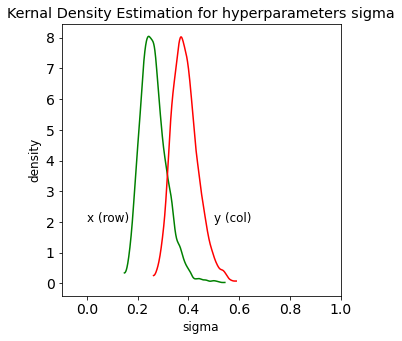

In [18]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

az.plot_kde(partial_inf.posterior.sigma_x.values, ax=ax, plot_kwargs={"color": "green"})
az.plot_kde(partial_inf.posterior.sigma_y.values, ax=ax, plot_kwargs={"color": "red"})

ax.title.set_text('Kernal Density Estimation for hyperparameters sigma')
ax.text(0.0001, 2, "x (row)")
ax.text(0.5, 2, "y (col)")
ax.set_xlabel("sigma")
ax.set_ylabel("density")
ax.set_xlim(-0.1, 1);

In [19]:
# A sample of possible grid filled up
data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

pp = data.copy()
SIZE = 400

# retrieve samples from posterior distribution
a_bar_sample = partial_inf.posterior.a_bar.values.flatten()
sigma_x_sample = partial_inf.posterior.sigma_x.values.flatten()
sigma_y_sample = partial_inf.posterior.sigma_y.values.flatten()
x_sample = partial_inf.posterior.x.values.flatten()
y_sample = partial_inf.posterior.y.values.flatten()

for row in range(len(pp)):
    for col in range(len(pp[0])):
        if np.isnan(pp[row][col]):
            
            # 1 sample will be randomly chosen out of all the chains
            rand_samp = np.random.randint(0,3999)
            a_bar = a_bar_sample[rand_samp]
            sigma_x = sigma_x_sample[rand_samp]
            sigma_y = sigma_y_sample[rand_samp]
            x = x_sample[rand_samp+ row*4000]
            y = y_sample[rand_samp + col*4000]
            
            # Likelihood + The Prediction!
            l = SIZE*np.exp(a_bar + x*sigma_x + y*sigma_y)
            counts = sts.poisson(mu=l).rvs()
            pp[row][col] = counts


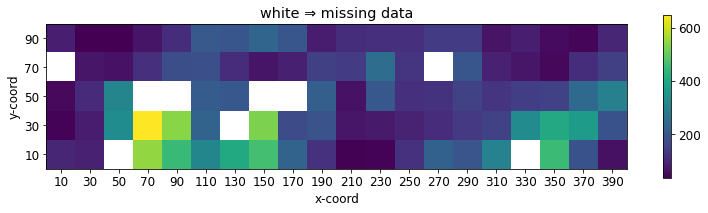

In [20]:
# Initial Grid
plt.figure(figsize=(13, 3))
plt.title('white ⇒ missing data')
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

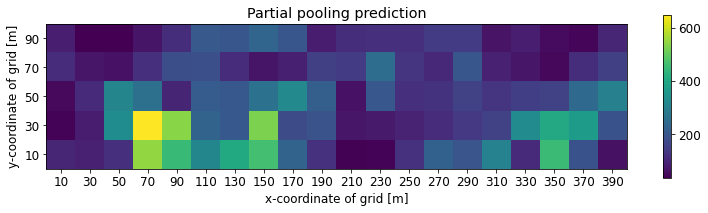

In [21]:
# Partial Pooling prediction
plt.figure(figsize=(13, 3))
plt.title('Partial pooling prediction')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(pp, origin='lower')
plt.xticks(np.arange(pp.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(pp.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()